<a href="https://colab.research.google.com/github/kopapatzimos/distracted_driver_detection_VGG16/blob/main/kaggle_distracted_drivers_using_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extract Data from Kaggle

In [ ]:
#this code takes the data from competition state-farm-distracted-driver-detection
#saves the data in google colab

from google.colab import files
!pip install -q kaggle
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle competitions download -c state-farm-distracted-driver-detection
!unzip state-farm-distracted-driver-detection


# Create Validation Folder

In [ ]:
import os
import shutil
import numpy as np

# Define directories
train_dir = "/content/imgs/train"
validation_dir = "/content/imgs/validation"

# Create validation directory if it doesn't exist
if not os.path.exists(validation_dir):
    os.makedirs(validation_dir)

# Define the percentage of data to use for validation
validation_split = 0.2  # 20% of data for validation

# Get class directories
class_dirs = [os.path.join(train_dir, cls) for cls in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, cls))]

# Iterate over class directories
for class_dir in class_dirs:
    # Create class directory in the validation set
    class_name = os.path.basename(class_dir)
    validation_class_dir = os.path.join(validation_dir, class_name)
    if not os.path.exists(validation_class_dir):
        os.makedirs(validation_class_dir)

    # Get image files
    image_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

    # Randomly select files for validation
    num_validation_files = int(len(image_files) * validation_split)
    validation_files = np.random.choice(image_files, size=num_validation_files, replace=False)

    # Move validation files to validation directory
    for file in validation_files:
        src = os.path.join(class_dir, file)
        dst = os.path.join(validation_class_dir, file)
        shutil.move(src, dst)

print("Validation dataset created successfully.")

Validation dataset created successfully.


# Step 1: Data Preparation



Found 17943 files belonging to 10 classes.
Found 4481 files belonging to 10 classes.
Found 79726 files belonging to 1 classes.


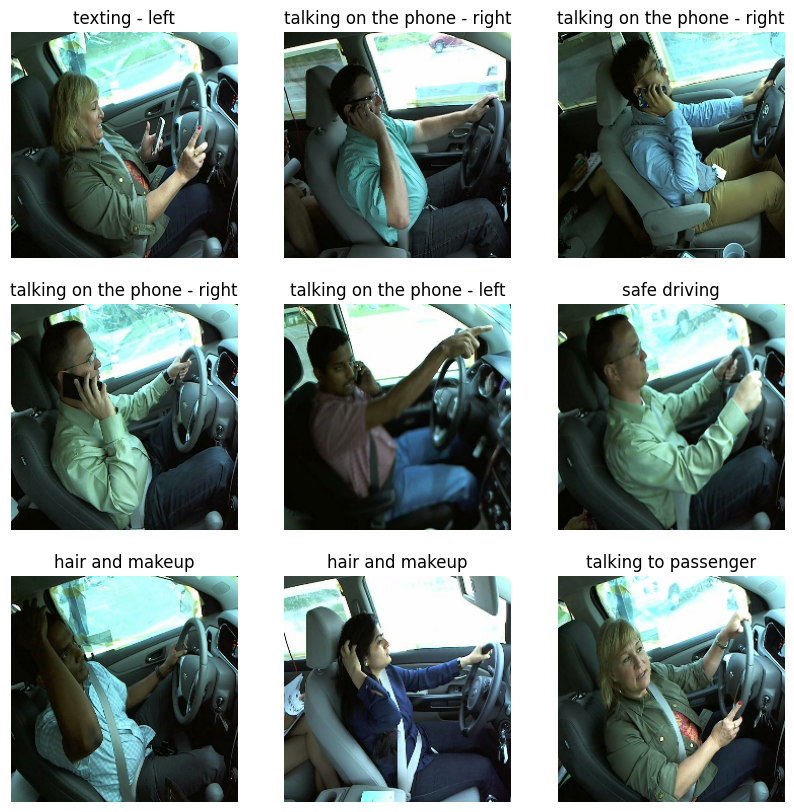

In [52]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Define data directories
train_dir = "/content/imgs/train"
test_dir = "/content/imgs/test"
validation_dir = "/content/imgs/validation"

# Define batch size
batch_size = 64
num_epochs = 10

# Define image size
image_size = (224, 224)

# Define data augmentation and normalization layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

# Define the class dictionary
class_dict = {
    0: "safe driving",
    1: "texting - right",
    2: "talking on the phone - right",
    3: "texting - left",
    4: "talking on the phone - left",
    5: "operating the radio",
    6: "drinking",
    7: "reaching behind",
    8: "hair and makeup",
    9: "talking to passenger"
}


# Load and prepare training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
)

# Load and prepare training dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
)



# Load and prepare testing dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode=None,
    shuffle=False,
)

# Visualize data with class names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_dict[tf.argmax(labels[i]).numpy()])
        plt.axis("off")
plt.show()


Validation dataset created successfully.


# Step 2: Model Definition (VGG16)

In [ ]:
import tensorflow as tf

# Define VGG16 model
base_model = tf.keras.applications.VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze convolutional layers
base_model.trainable = True


# Add classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(units=len(class_dict), activation='softmax')

# Create model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam()

# Define the loss function
loss_function = tf.keras.losses.CategoricalCrossentropy()

# Define metrics
metrics = ['accuracy']

# Define the learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(patience=3)

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Compile the model
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metrics)

# Train the model
history = model.fit(train_ds,
                    epochs=num_epochs,
                    validation_data=test_ds,
                    callbacks=[lr_scheduler, early_stopping])



# Display model summary
model.summary()


58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/10
351/351 [==============================] - 134s 335ms/step - loss: 2.3817 - accuracy: 0.1062 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/10
351/351 [==============================] - ETA: 0s - loss: 2.3004 - accuracy: 0.1110

KeyboardInterrupt: 

# Step 3: Models Training


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model

# Define data directories
train_dir = "/content/imgs/train"
test_dir = "/content/imgs/test"
validation_dir = "/content/imgs/validation"

# Define batch size
batch_size = 64
num_epochs = 10

# Define image size
image_size = (224, 224)

# Define data augmentation and normalization layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

# Load and prepare training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
    seed=42
)

# Load and prepare training dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False,
    seed=42
)



# Load and prepare testing dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode=None,
    shuffle=False,
    seed=42
)

# Define MobileNetV2 base model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze convolutional layers
base_model.trainable = True

# Add classification head
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(units=10, activation='softmax')

# Create model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = Model(inputs, outputs)

# Define the optimizer
optimizer = Adam()

# Define the loss function
loss_function = CategoricalCrossentropy()

# Define metrics
metrics = ['accuracy']

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(patience=3)

# Define early stopping
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Compile the model
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metrics)

# Train the model
history = model.fit(train_ds,
                    epochs=num_epochs,
                    validation_data=validation_ds,
                    callbacks=[lr_scheduler, early_stopping])

# Display model summary
model.summary()

Found 17943 files belonging to 10 classes.
Found 4481 files belonging to 10 classes.
Found 79726 files belonging to 1 classes.
9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/10
281/281 [==============================] - 60s 122ms/step - loss: 2.3467 - accuracy: 0.0994 - val_loss: 2.3237 - val_accuracy: 0.1033 - lr: 0.0010
Epoch 2/10
281/281 [==============================] - 32s 113ms/step - loss: 2.3139 - accuracy: 0.1019 - val_loss: 2.3168 - val_accuracy: 0.1047 - lr: 0.0010
Epoch 3/10
281/281 [==============================] - 32s 114ms/step - loss: 2.3147 - accuracy: 0.1025 - val_loss: 2.3202 - val_accuracy: 0.1047 - lr: 0.0010
Epoch 4/10
281/281 [==============================] - 32s 115ms/step - loss: 2.3133 - accuracy: 0.1011 - val_loss: 2.3248 - val_accuracy: 0.1047 - lr: 0.0010
Epoch 5/10
281/281 [==============================] - 32s 114ms/step - loss: 2.3142 - accuracy: 0.1034 - val_loss: 2.3382 - val_accuracy: 0.1047 - lr: 0.0010
Epoch 6/10
281/281 [

Found 17943 files belonging to 10 classes.
Found 4481 files belonging to 10 classes.
Found 79726 files belonging to 1 classes.
94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/10
281/281 [==============================] - 205s 713ms/step - loss: 2.3019 - accuracy: 0.1234 - val_loss: 6.8933 - val_accuracy: 0.0942 - lr: 0.0010
Epoch 2/10
281/281 [==============================] - 198s 705ms/step - loss: 2.2694 - accuracy: 0.1448 - val_loss: 11.1964 - val_accuracy: 0.0911 - lr: 0.0010
Epoch 3/10
281/281 [==============================] - 196s 696ms/step - loss: 2.2465 - accuracy: 0.1644 - val_loss: 17.3948 - val_accuracy: 0.0922 - lr: 0.0010
Epoch 4/10
147/281 [==============>...............] - ETA: 1:32 - loss: 2.2354 - accuracy: 0.1735

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

# Define data directories
train_dir = "/content/imgs/train"
test_dir = "/content/imgs/test"

# Define batch size and number of epochs
batch_size = 64
num_epochs = 10

# Define image size
image_size = (224, 224)

# Load and prepare training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
    seed=42
)

# Load and prepare validation dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False,
    seed=42
)

# Load and prepare testing dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode=None,
    shuffle=False,
    seed=42
)

# Define the base model (ResNet50) with pre-trained weights
base_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model layers
base_model.trainable = False

# Add classification head
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(units=10, activation='softmax')

# Create the model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = Model(inputs, outputs)

# Compile the model
optimizer = Adam()
loss_function = CategoricalCrossentropy()
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(patience=3)

# Define early stopping
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
history = model.fit(train_ds, epochs=num_epochs, validation_data=validation_ds, callbacks=[lr_scheduler, early_stopping])

# Display model summary
model.summary()


Found 17943 files belonging to 10 classes.
Found 4481 files belonging to 10 classes.
Found 79726 files belonging to 1 classes.
Epoch 1/10
281/281 [==============================] - 28s 89ms/step - loss: 1.0685 - accuracy: 0.6880 - val_loss: 0.5372 - val_accuracy: 0.8766 - lr: 0.0010
Epoch 2/10
281/281 [==============================] - 24s 86ms/step - loss: 0.3904 - accuracy: 0.9185 - val_loss: 0.3065 - val_accuracy: 0.9357 - lr: 0.0010
Epoch 3/10
281/281 [==============================] - 24s 86ms/step - loss: 0.2489 - accuracy: 0.9529 - val_loss: 0.2216 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 4/10
281/281 [==============================] - 24s 86ms/step - loss: 0.1844 - accuracy: 0.9641 - val_loss: 0.1838 - val_accuracy: 0.9603 - lr: 0.0010
Epoch 5/10
281/281 [==============================] - 24s 85ms/step - loss: 0.1437 - accuracy: 0.9746 - val_loss: 0.1505 - val_accuracy: 0.9665 - lr: 0.0010
Epoch 6/10
281/281 [==============================] - 24s 86ms/step - loss: 0.1187 - acc

Found 17943 files belonging to 10 classes.
Found 79726 files belonging to 1 classes.


NameError: name 'validation_ds' is not defined

1/1 [==============================] - 0s 19ms/step
14491


KeyError: 14491

In [ ]:
from keras.models import Sequential,Model
import os
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import secrets
import cv2
from PIL import Image
from PIL import ImageFile
from sklearn.datasets import load_files
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.models import Sequential,Model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil


from PIL import ImageFile
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tqdm import tqdm
from keras import optimizers
from keras.applications.vgg16 import VGG16
import seaborn as sns
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
model = VGG16(include_top=False)
model.summary()
model.output_shape[1:]
vgg16_model_fine_tuned = Sequential()
vgg16_model_fine_tuned.add(GlobalAveragePooling2D(input_shape=model.output_shape[1:]))
vgg16_model_fine_tuned.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))
vgg16_model_fine_tuned = Model(inputs = model.input, outputs = vgg16_model_fine_tuned(model.output))

vgg16_model_fine_tuned.summary()
for layer in vgg16_model_fine_tuned.layers[:15]:
    layer.trainable = False

vgg16_model_fine_tuned.compile(loss='categorical_crossentropy',optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9),metrics=['accuracy'])
MODEL_PATH = os.path.join(os.getcwd(),"model","vgg16_fine_tuned")

filepath = os.path.join(MODEL_PATH,"distracted-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,mode='max',period=1)
callbacks_list = [checkpoint]

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
model_history = vgg16_model_fine_tuned.fit(train_ds,validation_data = validation_ds,epochs=25, shuffle=True,callbacks=callbacks_list)


Epoch 1/25
281/281 [==============================] - ETA: 0s - loss: 1.8808 - accuracy: 0.3814
Epoch 1: val_accuracy improved from -inf to 0.79268, saving model to /content/model/vgg16_fine_tuned/distracted-01-0.79.hdf5
281/281 [==============================] - 33s 111ms/step - loss: 1.8808 - accuracy: 0.3814 - val_loss: 0.7415 - val_accuracy: 0.7927
Epoch 2/25


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


280/281 [============================>.] - ETA: 0s - loss: 0.3596 - accuracy: 0.9021
Epoch 2: val_accuracy improved from 0.79268 to 0.94644, saving model to /content/model/vgg16_fine_tuned/distracted-02-0.95.hdf5
281/281 [==============================] - 31s 111ms/step - loss: 0.3593 - accuracy: 0.9022 - val_loss: 0.2079 - val_accuracy: 0.9464
Epoch 3/25
280/281 [============================>.] - ETA: 0s - loss: 0.1333 - accuracy: 0.9698
Epoch 3: val_accuracy improved from 0.94644 to 0.97389, saving model to /content/model/vgg16_fine_tuned/distracted-03-0.97.hdf5
281/281 [==============================] - 31s 111ms/step - loss: 0.1331 - accuracy: 0.9698 - val_loss: 0.1056 - val_accuracy: 0.9739
Epoch 4/25
280/281 [============================>.] - ETA: 0s - loss: 0.0766 - accuracy: 0.9835
Epoch 4: val_accuracy improved from 0.97389 to 0.97992, saving model to /content/model/vgg16_fine_tuned/distracted-04-0.98.hdf5
281/281 [==============================] - 31s 111ms/step - loss: 0.076

1/1 [==============================] - 0s 131ms/step


KeyError: 14491

1/1 [==============================] - 0s 19ms/step
[[0.15821329 0.03968306 0.0817989  0.08989688 0.26350304 0.05449449
  0.07817847 0.04642856 0.0713038  0.11649943]]


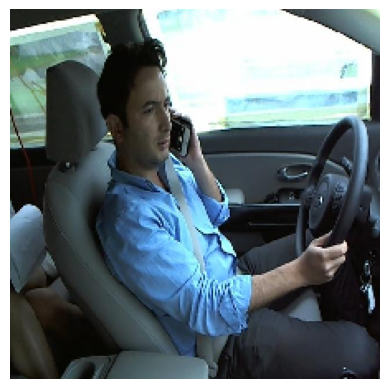

Predicted Class: 4


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_image(model, image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize the image

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    return predicted_class

# Example usage
model = vgg16_model_fine_tuned  # Load your trained model here
image_path = "/content/imgs/test/img_1.jpg"
predicted_class = predict_image(model, image_path)
print("Predicted Class:", predicted_class)


## Base model






In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
class StopByAccuracyCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.95):
        super(StopByAccuracyCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') is not None and logs.get('val_accuracy') >= self.threshold:
            print(f"\nReached {self.threshold}% validation accuracy. Stopping training.")
            self.model.stop_training = True

class DriverVgg16:
    def __init__(self, input_width, input_height):
        self.input_shape = (input_width, input_height, 3)
        self.classes = 10
        self.model = None
        self.build_model()

    def build_model(self):
        vgg16 = VGG16(weights='imagenet', input_shape=self.input_shape, classes=self.classes, include_top=False)

        for layer in vgg16.layers:
            layer.trainable = False

        x = Flatten()(vgg16.output)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)
        predictions = Dense(self.classes, activation='softmax')(x)

        self.model = Model(inputs=vgg16.input, outputs=predictions)
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Create an instance of DriverVgg16
input_width = 224  # Define your input width
input_height = 224  # Define your input height
driver = DriverVgg16(input_width, input_height)

driver.model.fit(
    train_ds,
    epochs=10,
    validation_data=validation_ds,
    callbacks=[StopByAccuracyCallback()]
)

Epoch 1/10
281/281 [==============================] - 84s 296ms/step - loss: 4.6211 - accuracy: 0.2567 - val_loss: 1.5914 - val_accuracy: 0.4173
Epoch 2/10
281/281 [==============================] - 85s 303ms/step - loss: 1.8460 - accuracy: 0.2993 - val_loss: 1.3613 - val_accuracy: 0.4724
Epoch 3/10
281/281 [==============================] - 87s 307ms/step - loss: 1.7905 - accuracy: 0.3209 - val_loss: 1.5812 - val_accuracy: 0.4068
Epoch 4/10
281/281 [==============================] - 86s 306ms/step - loss: 1.8032 - accuracy: 0.3057 - val_loss: 1.3706 - val_accuracy: 0.4749
Epoch 5/10
281/281 [==============================] - 86s 306ms/step - loss: 1.7266 - accuracy: 0.3314 - val_loss: 1.2692 - val_accuracy: 0.5325
Epoch 6/10
281/281 [==============================] - 86s 306ms/step - loss: 1.6823 - accuracy: 0.3517 - val_loss: 1.1568 - val_accuracy: 0.5579
Epoch 7/10
281/281 [==============================] - 86s 305ms/step - loss: 1.6423 - accuracy: 0.3666 - val_loss: 1.0893 - val_ac

## Add more dense layers to improve the model

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
class ImprovedDriverVgg16:
    def __init__(self, input_width, input_height):
        self.input_shape = (input_width, input_height, 3)
        self.classes = 10
        self.model = None
        self.build_model()

    def build_model(self):
        vgg16 = VGG16(weights='imagenet', input_shape=self.input_shape, include_top=False)

        # Freeze all layers in VGG16
        for layer in vgg16.layers:
            layer.trainable = False

        x = Flatten()(vgg16.output)
        x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
        x = Dropout(0.5)(x)
        x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
        x = Dropout(0.5)(x)

        # Add additional dense layers
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.3)(x)

        predictions = Dense(self.classes, activation='softmax')(x)

        self.model = Model(inputs=vgg16.input, outputs=predictions)

        # Unfreeze the last convolutional block for fine-tuning
        for layer in self.model.layers[-4:]:
            layer.trainable = True

        self.model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


# Create an instance of ImprovedDriverVgg16
input_width = 224  # Define your input width
input_height = 224  # Define your input height
driver = ImprovedDriverVgg16(input_width, input_height)

# Add ReduceLROnPlateau callback for learning rate scheduling
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Define the path to save the best weights
checkpoint_path = "best_weights.h5"

# Add ModelCheckpoint callback to save the best weights based on validation accuracy
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                              monitor='val_accuracy',
                              save_best_only=True,
                              mode='max',
                              verbose=1)

# Fitting the model with callbacks
history = driver.model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[reduce_lr, checkpoint]
)


## Remove Flatten layer and use GlobalAveragePooling2D

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D

class ImprovedDriverVgg16:
    def __init__(self, input_width, input_height):
        self.input_shape = (input_width, input_height, 3)
        self.classes = 10
        self.model = None
        self.build_model()

    def build_model(self):
        vgg16 = VGG16(weights='imagenet', input_shape=self.input_shape, include_top=False)

        # Freeze all layers in VGG16
        for layer in vgg16.layers:
            layer.trainable = False

        x = vgg16.output
        x = GlobalAveragePooling2D()(x)  # Add GlobalAveragePooling layer
        x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
        x = Dropout(0.5)(x)
        x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
        x = Dropout(0.5)(x)

        # Add additional dense layers
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.3)(x)

        predictions = Dense(self.classes, activation='softmax')(x)

        self.model = Model(inputs=vgg16.input, outputs=predictions)

        # Unfreeze the last convolutional block for fine-tuning
        for layer in self.model.layers[-4:]:
            layer.trainable = True

        self.model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# Fitting the model with callbacks
history = driver.model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[reduce_lr, checkpoint]
)

Epoch 1/50
281/281 [==============================] - ETA: 0s - loss: 1.9042 - accuracy: 0.2787
Epoch 1: val_accuracy improved from 0.43249 to 0.44834, saving model to best_weights.h5
281/281 [==============================] - 88s 313ms/step - loss: 1.9042 - accuracy: 0.2787 - val_loss: 1.5234 - val_accuracy: 0.4483 - lr: 0.0010
Epoch 2/50
281/281 [==============================] - ETA: 0s - loss: 1.8539 - accuracy: 0.2901
Epoch 2: val_accuracy did not improve from 0.44834
281/281 [==============================] - 87s 310ms/step - loss: 1.8539 - accuracy: 0.2901 - val_loss: 1.5987 - val_accuracy: 0.4019 - lr: 0.0010
Epoch 3/50
281/281 [==============================] - ETA: 0s - loss: 1.8258 - accuracy: 0.2986
Epoch 3: val_accuracy did not improve from 0.44834
281/281 [==============================] - 87s 309ms/step - loss: 1.8258 - accuracy: 0.2986 - val_loss: 1.5048 - val_accuracy: 0.4419 - lr: 0.0010
Epoch 4/50
281/281 [==============================] - ETA: 0s - loss: 1.7869 - ac

## Feature extraction Model

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class FeatureExtractionDriverVgg16:
    def __init__(self, input_width, input_height):
        self.input_shape = (input_width, input_height, 3)
        self.classes = 10
        self.model = self.build_model()

    def build_model(self):
        # Load pre-trained VGG16 model without top layers
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=self.input_shape)

        # Freeze the convolutional base
        base_model.trainable = False

        # Add custom fully connected layers on top
        x = base_model.output
        x = GlobalAveragePooling2D()(x)  # Add GlobalAveragePooling layer

        x = Dense(512, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)
        predictions = Dense(self.classes, activation='softmax')(x)

        # Create the model
        model = Model(inputs=base_model.input, outputs=predictions)

        # Compile the model
        model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

        return model

# Define input width and height
input_width = 224
input_height = 224
batch_size = 64

# Create an instance of FeatureExtractionDriverVgg16
driver = FeatureExtractionDriverVgg16(input_width, input_height)

# Define data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(input_width, input_height),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(input_width, input_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Train the model
history = driver.model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)


Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.
Epoch 1/10
281/281 [==============================] - 91s 317ms/step - loss: 2.1778 - accuracy: 0.1910 - val_loss: 1.6931 - val_accuracy: 0.4294
Epoch 2/10
281/281 [==============================] - 89s 316ms/step - loss: 1.4824 - accuracy: 0.4636 - val_loss: 1.0286 - val_accuracy: 0.7121
Epoch 3/10
281/281 [==============================] - 89s 316ms/step - loss: 1.0501 - accuracy: 0.6368 - val_loss: 0.6437 - val_accuracy: 0.8172
Epoch 4/10
281/281 [==============================] - 89s 316ms/step - loss: 0.7962 - accuracy: 0.7281 - val_loss: 0.4401 - val_accuracy: 0.8775
Epoch 5/10
281/281 [==============================] - 89s 316ms/step - loss: 0.6729 - accuracy: 0.7752 - val_loss: 0.3522 - val_accuracy: 0.8962
Epoch 6/10
281/281 [==============================] - 89s 316ms/step - loss: 0.5961 - accuracy: 0.7999 - val_loss: 0.3142 - val_accuracy: 0.9148
Epoch 7/10
281/281 [=======================

## Feature Extraction X Fine Tuning X Re-Train Model  

In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import os

class FeatureExtractionDriverVgg16:
    def __init__(self, input_width, input_height, classes):
        self.input_shape = (input_width, input_height, 3)
        self.classes = classes
        self.model = self.build_model()

    def build_model(self):
        # Load pre-trained VGG16 model without top layers
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=self.input_shape)

        # Freeze the convolutional base
        base_model.trainable = False

        # Add custom fully connected layers on top
        x = base_model.output
        x = GlobalAveragePooling2D()(x)  # Add GlobalAveragePooling layer

        x = Dense(512, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)
        predictions = Dense(self.classes, activation='softmax')(x)

        # Create the model
        model = Model(inputs=base_model.input, outputs=predictions)

        # Compile the model
        model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

        return model

# Define input width and height
input_width = 224
input_height = 224
batch_size = 64
num_classes = 10  # Define the number of classes in your dataset

# Create an instance of FeatureExtractionDriverVgg16
driver = FeatureExtractionDriverVgg16(input_width, input_height, num_classes)

# Define data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(input_width, input_height),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(input_width, input_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Train the model for feature extraction
feature_extraction_epochs = 5
history_feature_extraction = driver.model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=feature_extraction_epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

# Fine-tune the model
fine_tune_epochs = feature_extraction_epochs + 10
for layer in driver.model.layers[:-10]:
    layer.trainable = True

# Reduce learning rate during fine-tuning
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Define the path to save the best weights during fine-tuning
checkpoint_path = "best_weights_fine_tuning.h5"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

# Refit the model
history_fine_tune = driver.model.fit(
    train_generator,
    epochs=fine_tune_epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    initial_epoch=history_feature_extraction.epoch[-1],
    callbacks=[reduce_lr, checkpoint]
)


Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.
Epoch 1/5
281/281 [==============================] - 91s 317ms/step - loss: 2.1350 - accuracy: 0.2097 - val_loss: 1.5931 - val_accuracy: 0.4867
Epoch 2/5
281/281 [==============================] - 89s 316ms/step - loss: 1.4241 - accuracy: 0.4813 - val_loss: 0.9860 - val_accuracy: 0.7016
Epoch 3/5
281/281 [==============================] - 89s 315ms/step - loss: 1.0360 - accuracy: 0.6342 - val_loss: 0.7375 - val_accuracy: 0.7652
Epoch 4/5
281/281 [==============================] - 89s 316ms/step - loss: 0.8256 - accuracy: 0.7155 - val_loss: 0.5168 - val_accuracy: 0.8536
Epoch 5/5
281/281 [==============================] - 89s 315ms/step - loss: 0.7238 - accuracy: 0.7522 - val_loss: 0.4126 - val_accuracy: 0.8962
Epoch 5/15
281/281 [==============================] - ETA: 0s - loss: 0.6439 - accuracy: 0.7792
Epoch 5: val_accuracy improved from -inf to 0.91230, saving model to best_weights_fine_tuning.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


281/281 [==============================] - ETA: 0s - loss: 0.6058 - accuracy: 0.7927
Epoch 6: val_accuracy improved from 0.91230 to 0.91408, saving model to best_weights_fine_tuning.h5
281/281 [==============================] - 89s 317ms/step - loss: 0.6058 - accuracy: 0.7927 - val_loss: 0.3031 - val_accuracy: 0.9141 - lr: 0.0010
Epoch 7/15
281/281 [==============================] - ETA: 0s - loss: 0.5713 - accuracy: 0.8055
Epoch 7: val_accuracy did not improve from 0.91408
281/281 [==============================] - 88s 314ms/step - loss: 0.5713 - accuracy: 0.8055 - val_loss: 0.3002 - val_accuracy: 0.9139 - lr: 0.0010
Epoch 8/15
281/281 [==============================] - ETA: 0s - loss: 0.5608 - accuracy: 0.8086
Epoch 8: val_accuracy improved from 0.91408 to 0.92680, saving model to best_weights_fine_tuning.h5
281/281 [==============================] - 89s 315ms/step - loss: 0.5608 - accuracy: 0.8086 - val_loss: 0.2479 - val_accuracy: 0.9268 - lr: 0.0010
Epoch 9/15
281/281 [===========

# Step 4: Create Predictions for Test Images

In [ ]:
# Load and prepare testing dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=batch_size,
    label_mode=None,
    shuffle=False,
)


In [30]:
import tensorflow as tf

# Load and prepare testing dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=batch_size,
    label_mode=None,
    shuffle=False,
)

# Define a rescaling layer
rescale_layer = tf.keras.layers.Rescaling(scale=1./255)

# Apply the rescaling layer to the dataset
test_ds = test_ds.map(lambda x: rescale_layer(x))


# Use the loaded model to predict on the test data
predictions = loaded_model.predict(test_ds)

# Define the class dictionary
class_dict = {
    0: "safe driving",
    1: "texting - right",
    2: "talking on the phone - right",
    3: "texting - left",
    4: "talking on the phone - left",
    5: "operating the radio",
    6: "drinking",
    7: "reaching behind",
    8: "hair and makeup",
    9: "talking to passenger"
}

predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = [class_dict[idx] for idx in predicted_classes]

# Define the directory containing the test images
test_dir = "/content/imgs/test"

# Get a list of all files in the test directory
files = os.listdir(test_dir)

# Filter out only the image files (assuming common image extensions)
image_files = [file for file in files if file.endswith(('.jpg', '.jpeg', '.png'))]

# Create a list of full paths to the image files
image_file_paths = [os.path.join(test_dir, file) for file in image_files]

# Sort the list of image file paths alphabetically
sorted_image_file_paths = sorted(image_file_paths)

# Display the sorted list of image file paths
print(sorted_image_file_paths)
# Assuming you already have 'sorted_image_file_paths' and 'predicted_labels' lists

# Zip the sorted list of image file paths with the predicted labels
zipped_data = list(zip(sorted_image_file_paths, predicted_labels))




Found 79726 files belonging to 1 classes.
1246/1246 [==============================] - 312s 250ms/step


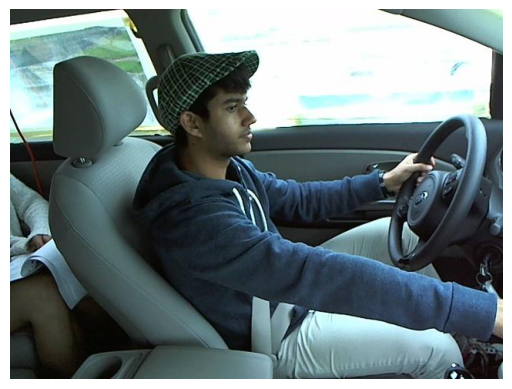

Predicted Class: operating the radio


In [61]:
from PIL import Image
import matplotlib.pyplot as plt

def display_image_with_prediction(image_name, zipped_data):
    # Find the corresponding image path in the zipped data
    for image_path, predicted_label in zipped_data:
        if image_name in image_path:
            # Load and display the image
            img = Image.open(image_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()

            # Print the predicted class name
            print("Predicted Class:", predicted_label)
            return

    # If the image name is not found
    print("Image not found in the dataset.")

# Example usage:
# Assuming 'zipped_data' contains the zipped data of image file paths and predicted labels
# Replace 'image_name' with the name of the image you want to display
image_name = 'img_100081.jpg'
display_image_with_prediction(image_name, zipped_data)
